In [1]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns

In [19]:
RANDOM_SEED = 42

In [59]:
train_df = pd.read_csv('antenna.csv')

In [60]:
train_df.head()

,Wm,W0m,dm,tm,rows,Xa,Ya,gain,vswr,bandwidth,s,pr,p0
0,2142.9,162.86,77.143,214.29,3.0,0.0,2142.9,2.799175,1.372040,110.6698,-16.090654,0.204248,0.483952
1,2142.9,162.86,77.143,214.29,3.0,3543.5,6964.3,2.817305,1.638103,120.7497,-12.328015,0.197374,0.464289
2,2142.9,162.86,351.430,214.29,5.0,8365.0,6964.3,2.941413,1.242714,123.6901,-19.313586,0.212885,0.490808
3,2142.9,162.86,351.430,214.29,3.0,8365.0,2142.9,2.844078,1.242587,122.4301,-19.317644,0.212405,0.496603
4,2142.9,162.86,351.430,214.29,3.0,8365.0,6964.3,2.812315,1.271176,124.3198,-18.459992,0.207997,0.489240


In [61]:
train_df.drop(columns=['bandwidth'],axis=1,inplace=True)

In [62]:
# defining columns;
# Wm: Width and height of SRR cell
# W0m: Gap between rings
# dm: distance between rings
# tm: width of rings
# rows: number of SRR cell in array
# Xa: distance between antenna patch and array
# Ya: distance bewtween SRR cell in the array
# gain: antenna gain
# vswr: wolatage standing wave ratio of the antenna 
# badnwidth: badnwitdth of antenna 
# s: return loss of the antenna 
# pr: power radiated by antenna 
# p0:  power accepted by antenna 


In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572 entries, 0 to 571
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Wm      572 non-null    float64
 1   W0m     572 non-null    float64
 2   dm      572 non-null    float64
 3   tm      572 non-null    float64
 4   rows    572 non-null    float64
 5   Xa      572 non-null    float64
 6   Ya      572 non-null    float64
 7   gain    572 non-null    float64
 8   vswr    572 non-null    float64
 9   s       572 non-null    float64
 10  pr      572 non-null    float64
 11  p0      572 non-null    float64
dtypes: float64(12)
memory usage: 53.8 KB


In [64]:
train_df.isna().sum()

Wm      0
W0m     0
dm      0
tm      0
rows    0
Xa      0
Ya      0
gain    0
vswr    0
s       0
pr      0
p0      0
dtype: int64

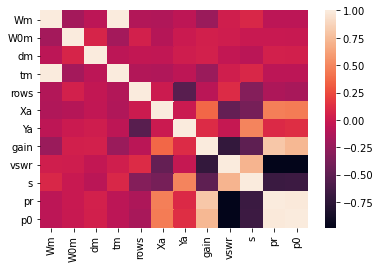

In [65]:
sns.heatmap(train_df.corr())

In [66]:
x = train_df.drop(columns=['pr','p0'])
y = train_df[['pr','p0']]

In [67]:
from sklearn.preprocessing import RobustScaler

In [68]:
rc = RobustScaler()
x = rc.fit_transform(x)

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.15,random_state=RANDOM_SEED)

In [71]:
y_train_pr = y_train['pr'].values
y_train_p0 = y_train['p0'].values
y_val_pr = y_val['pr'].values
y_val_p0 = y_val['p0'].values

In [72]:
x_train = np.array(x_train)
x_val = np.array(x_val)

In [73]:
x_train.shape

(486, 10)

In [2]:
from keras.layers import Dense,Dropout,BatchNormalization,Input
from keras.models import Model
import pydot
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from livelossplot import PlotLossesKeras

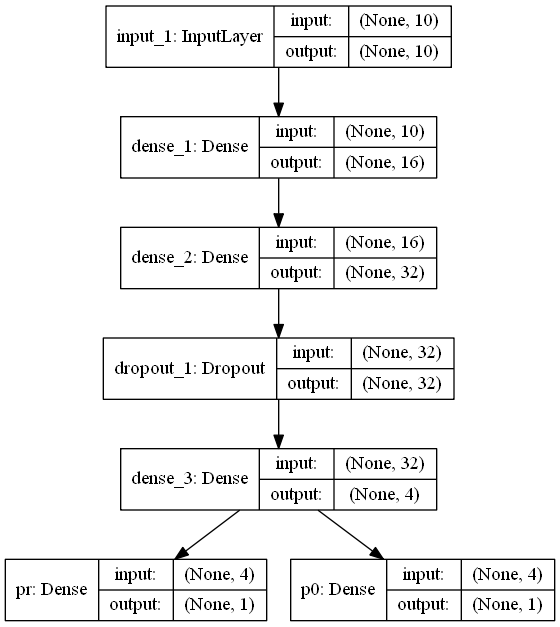

In [3]:
input_layer = Input(shape=(10,))
x = Dense(16,activation='relu')(input_layer)
x = Dense(32,activation='relu')(x)
x = Dropout(0.4)(x)
bottle_neck = Dense(4)(x)
out_pr = Dense(1,activation='linear',name='pr')(bottle_neck)
out_p0 = Dense(1,activation='linear',name='p0')(bottle_neck)

model = Model(inputs=input_layer,outputs=[out_pr,out_p0])
model.compile(optimizer='adam',loss={'pr':'mse','p0':'mse'},metrics={'pr':'mae','p0':'mae'})
plot_model(model,to_file='model_plot.png',show_shapes=True,show_layer_names=True)

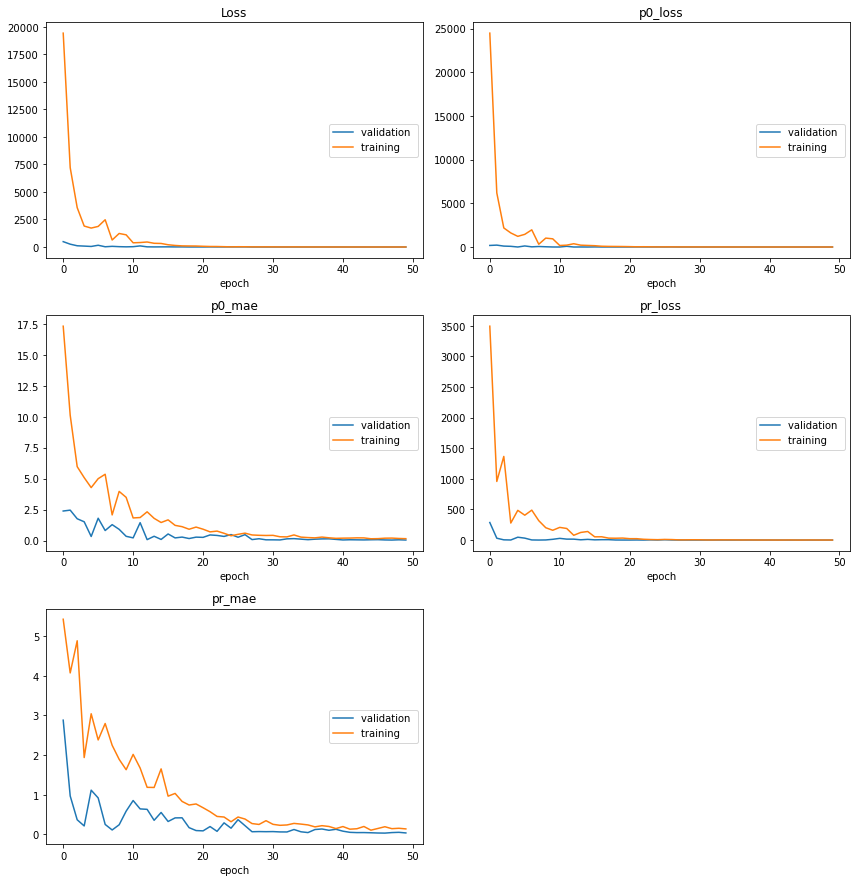

Loss
	validation       	 (min:    0.039, max:  487.556, cur:    0.039)
	training         	 (min:    0.676, max: 19436.598, cur:    0.884)
p0_loss
	validation       	 (min:    0.005, max:  216.047, cur:    0.006)
	training         	 (min:    0.370, max: 24493.725, cur:    0.370)
p0_mae
	validation       	 (min:    0.044, max:    2.460, cur:    0.046)
	training         	 (min:    0.149, max:   17.313, cur:    0.156)
pr_loss
	validation       	 (min:    0.023, max:  286.581, cur:    0.031)
	training         	 (min:    0.235, max: 3493.392, cur:    0.507)
pr_mae
	validation       	 (min:    0.034, max:    2.881, cur:    0.038)
	training         	 (min:    0.108, max:    5.426, cur:    0.140)


In [76]:
h = model.fit(x_train,[y_train_pr,y_train_p0],
                validation_data=(x_val,[y_val_pr,y_val_p0]),
                epochs=50,
                batch_size=5,
                callbacks=[PlotLossesKeras()])

In [ ]:
model.save('Final_Model')